In [1]:
from speedml import Speedml
import csv
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import math
import seaborn as sns
from collections import OrderedDict
%matplotlib inline
import pg8000
import sys
import os
import pathlib2

Upload data from home dir

In [2]:
home = pathlib2.Path.home()
full_path = home/"documents"/"github"/"SMART_goals"/"data"/"mouse_smart_data.csv"
full_path = str(full_path)
full_path
mdata = pd.read_csv(full_path)

Pull Recording date and set as index and change to datetime format 

In [4]:
mdata['recording_date'] = pd.to_datetime(mdata['recording_date'], format='%Y-%m-%d')
mdata.set_index(['recording_date'], inplace = True)
mdata.head()

,anno.res_index_label,patched_cell_container,name,63x_call
recording_date,,,,
2018-01-02,1.000000,P8S4_180102_351_A01,Chat-IRES-Cre-neo;Ai14-365769.04.02.01,63x go
2018-01-02,0.000000,P8S4_180102_352_A01,Chat-IRES-Cre-neo;Ai14-365769.04.02.02,NaN
2018-01-02,0.745543,P8S4_180102_353_A01,Chat-IRES-Cre-neo;Ai14-365769.05.02.01,NaN
2018-01-02,0.880454,P9S4_180102_401_A01,Pdyn-T2A-CreERT2;Ai14-366659.04.01.01,63x go
2018-01-02,1.000000,P9S4_180102_402_A01,Chat-IRES-Cre-neo;Ai14-365769.03.01.01,63x no go


Group Recording date with all other variables

In [5]:
mdata = mdata.groupby(['recording_date']).count()

mdata

,anno.res_index_label,patched_cell_container,name,63x_call
recording_date,,,,
2018-01-02,6,6,6,4
2018-01-03,4,4,4,3
2018-01-04,1,1,1,0
2018-01-08,19,19,19,9
2018-01-09,16,16,16,8
2018-01-10,22,22,22,9
2018-01-11,13,13,13,9
2018-01-12,16,16,16,11
2018-01-15,6,6,6,3


Change patched cell container to total pcc

In [6]:
mdata['total_pcc'] = mdata['patched_cell_container'].cumsum()

In [7]:
md = mdata.reset_index()

In [8]:
mdata_time = md[['recording_date', 'total_pcc']]
mdata_time.set_index(['recording_date'], inplace=True)

Set goal to 400 tubes

In [13]:
mdata_time['goal'] = 3500

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
mdata_time.head()

,total_pcc,goal
recording_date,,
2018-01-02,6,3500
2018-01-03,10,3500
2018-01-04,11,3500
2018-01-08,30,3500
2018-01-09,46,3500


Make line plot

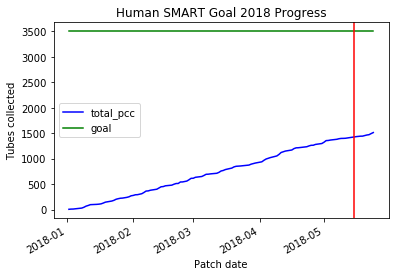

In [15]:
mdata_time.plot(color = ['b', 'g'])
plt.axvline('2018-05-15', color = 'r')
plt.xlabel('Patch date')
plt.ylabel('Tubes collected')
plt.title('Human SMART Goal 2018 Progress')
full_fig_path = str(home/"documents"/"github"/"SMART_goals"/"figures"/"mouse_total_pcc.png")
plt.savefig(full_fig_path, dpi=300)